<a href="https://colab.research.google.com/github/RaphBhz/Scenarformer/blob/main/Scenarformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
import random
import torch
import random
import torch
import os.path
from requests.exceptions import HTTPError
from transformers import CamembertTokenizer

DATA_PATH = F"/content/gdrive/MyDrive/AI/Scenarformer/plays/"

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
tokenizer.add_special_tokens({"additional_special_tokens": ["<newline>", "<TITRE>", "<ACTE>", "<SCENE>", "<DIALOGUE>", "</TITRE>", "</ACTE>", "</SCENE>", "</DIALOGUE>"]})

def load_play_text(path):
  with open(path, encoding="utf-8") as file:
    data = file.read()
    data = data.replace('\n', ' <newline> ')
    return data


def get_batch(play_files, batch_size, block_size, episode, steps_num, max_retries=15):
    num_plays = len(play_files)
    # Select a play based on episode index
    play_idx = episode % num_plays
    play_text = load_play_text(play_files[play_idx])

    # Convert the play text to tokens
    tokens = tokenizer.encode(play_text, return_tensors="pt").squeeze(0)

    for _ in range(steps_num):
        retries = 0
        while len(tokens) <= block_size:
            retries += 1
            if retries > max_retries:
                raise ValueError(
                    f"Failed to find a play file with sufficient length after {max_retries} retries. "
                )
            # Randomly select another play file
            play_idx = torch.randint(0, num_plays, (1,)).item()
            play_text = load_play_text(play_files[play_idx])
            tokens = tokenizer.encode(play_text, return_tensors="pt").squeeze(0)

        # Generate random starting indices for the batch
        start_idx = torch.randint(len(tokens) - block_size, (batch_size,))
        inputs = torch.stack([tokens[i:i+block_size] for i in start_idx])
        outputs = torch.stack([tokens[i+1:i+block_size+1] for i in start_idx])
        yield inputs, outputs



def split_files(play_dir = DATA_PATH, validation_ratio=0.1):
  # Get all .txt files in the directory
  all_files = [os.path.join(root, file)
                for root, _, files in os.walk(play_dir)
                for file in files if file.endswith('.txt')]

  # Shuffle the files
  random.shuffle(all_files)

  # Calculate the split index
  split_idx = int(len(all_files) * (1 - validation_ratio))

  # Split into training and validation
  train_files = all_files[:split_idx]
  val_files = all_files[split_idx:]

  return train_files, val_files

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Splitting the data into test and validation sets
train_files, validation_files = split_files()
print(f'Number of training plays: {len(train_files)}')
print(f'Number of validation plays: {len(validation_files)}')
print(f'Total: {len(train_files)+len(validation_files)}')

Number of training plays: 1717
Number of validation plays: 191
Total: 1908


# Model

In [ ]:
import torch
from torch import nn
import math


class SelfAttentionHead(nn.Module):
    def __init__(self, head_size, embedding_size, block_size, dropout):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embedding_size, head_size, bias=False)
        self.query = nn.Linear(embedding_size, head_size, bias=False)
        self.value = nn.Linear(embedding_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_size)  # Added LayerNorm
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        if torch.isnan(x).any():
            raise ValueError("Input contains NaNs")

        # Normalize inputs
        x = self.layer_norm(x)

        Batch, Block, Size = x.shape

        # Compute keys, queries, and values
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Compute attention scores
        scores = (queries @ keys.transpose(-2, -1)) / (self.head_size ** 0.5)

        # Apply the attention mask
        mask = self.mask[:Block, :Block]

        # Debugging and stability checks
        if torch.isnan(scores).any():
            raise ValueError("NaN detected in attention scores before softmax")
        if scores.abs().max() > 1e3:
            print(f"Warning: Extreme values in attention scores before softmax: {scores.abs().max().item()}")

        scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        weights = nn.functional.softmax(scores, dim=-1)

        if torch.isnan(weights).any():
            raise ValueError("NaN detected in attention weights after softmax")

        # Apply dropout to attention weights
        weights = self.dropout(weights)

        # Weighted sum of values
        out = weights @ values

        return out


class MultiHeadAttention(nn.Module):
  def __init__(self, head_size, num_heads, embedding_size, block_size, dropout):
    super().__init__()
    self.heads = nn.ModuleList(
      [SelfAttentionHead(head_size, embedding_size, block_size, dropout) for _ in range(num_heads)]
    )
    self.projection = nn.Linear(embedding_size, embedding_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    y = torch.cat([h(x) for h in self.heads], dim=-1)
    y = self.projection(y)
    y = self.dropout(y)
    return y


class FeedForwardLayer(nn.Module):
  def __init__(self, embedding_size, dropout):
    super().__init__()
    self.network = nn.Sequential(
      nn.Linear(embedding_size, 4 * embedding_size),
      nn.GELU(),
      nn.Linear(4 * embedding_size, embedding_size),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.network(x)


class DecoderBlock(nn.Module):
  def __init__(self, embedding_size, block_size, num_heads, dropout = 0.2):
    super().__init__()
    head_size = embedding_size // num_heads
    self.attention_heads = MultiHeadAttention(head_size, num_heads, embedding_size, block_size, dropout)
    self.feedforward_layer = FeedForwardLayer(embedding_size, dropout)
    self.layer_norm1 = nn.LayerNorm(embedding_size)
    self.layer_norm2 = nn.LayerNorm(embedding_size)

  def forward(self, x):
    x = x + self.attention_heads(self.layer_norm1(x))
    x = x + self.feedforward_layer(self.layer_norm2(x))
    return x



class SimpleModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, block_size, layer_num=6, attention_heads=8, dropout=0.2):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, embedding_size)
    self.position_embedding_table = nn.Embedding(block_size, embedding_size)
    self.decoder_blocks = nn.Sequential(
      *[DecoderBlock(embedding_size, block_size, num_heads=attention_heads, dropout=dropout) for _ in range(layer_num)],
      nn.LayerNorm(embedding_size)
    )
    self.linear_layer = nn.Linear(embedding_size, vocab_size)

  def forward(self, idx, targets=None):
    Batch, Block = idx.shape

    token_embeddings = self.token_embedding_table(idx)
    positional_embeddings = self.position_embedding_table(
        torch.arange(Block, device=idx.device)
    ).unsqueeze(0)
    embeddings = token_embeddings + positional_embeddings
    embeddings = self.decoder_blocks(embeddings)

    logits = self.linear_layer(embeddings)

    if targets is None:
      loss = None
    else:
      Batch, Block, Vocab = logits.shape
      logits = logits.view(Batch * Block, Vocab)
      targets = targets.view(Batch * Block)
      loss = nn.functional.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max, temperature=1.0, top_k=None):
    Batch, Block = idx.shape

    for _ in range(max):
        cropped_idx = idx[:, -Block:]
        logits, _ = self(cropped_idx)

        # Focus only on the last time step
        logits = logits[:, -1, :] / temperature

        if top_k is not None:
            # Apply top-k sampling
            top_values, top_indices = torch.topk(logits, top_k, dim=-1)
            logits = torch.full_like(logits, float('-inf'))
            logits.scatter_(1, top_indices, top_values)

        probs = nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


def initialize_weights(module):
    if isinstance(module, nn.Linear):
        # Xavier initialization for linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        # Normal initialization for embeddings
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        # Standard initialization for LayerNorm
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.ModuleList):
        # Recursively initialize each module in the list
        for sub_module in module:
            initialize_weights(sub_module)


# Training

## Parameters

In [ ]:
from datetime import datetime
import torch
import os.path

# Making sure the model uses GPU
torch.set_default_device('cuda')

# Part of data used for validation
VALIDATION_RATIO = 0.2

# Number of sequences to train at a time
BATCH_SIZE = 32
# Size of each sequence
BLOCK_SIZE = 512
# Size of embeddings
EMBEDDING_SIZE = 768
# Number of episodes to train for
TRAIN_EPISODES = 30
# Number of steps in each episode
TRAIN_STEPS = 500
# Number of steps in the validation
VALIDATION_STEPS = 250
# Number of episodes of the warmup phase
WARMUP_EPISODES = 4
# Number of episodes of the linear phase
LINEAR_EPISODES = 2
# Learning rate
LEARNING_RATE = 1e-7
# Max norm
MAX_NORM = 1.0
# Number of Layers for the Transformers Model's Decoder Block
LAYER_NUM = 12
# Number of Attention Heads of the Transformers Model
ATTENTION_HEADS = 12
# Dropout value for the model
DROPOUT = 0.2

# Path to save the model to
def MODEL_PATH(episode, date = None):
  model_name = f'model_{datetime.today().strftime("%Y-%m-%d-%H") if date is None else date}_{episode}.pth'
  return f"/content/gdrive/MyDrive/AI/Scenarformer/{model_name}"

## Training Loop

### Checkpoint 1

### Training

In [ ]:
from torch.amp import autocast, GradScaler
import torch.nn.utils as nn_utils

# Creating the model
m = SimpleModel(
  vocab_size=len(tokenizer),
  embedding_size=EMBEDDING_SIZE,
  block_size = BLOCK_SIZE,
  layer_num=LAYER_NUM,
  attention_heads=ATTENTION_HEADS,
  dropout=DROPOUT
)
m.cuda()

# Apply the initialization function (causes nan losses atm)
m.apply(initialize_weights)

# Using torch's Adam optimizer
# Initialize AdamW optimizer
optimizer = torch.optim.AdamW(
    m.parameters(),             # Model parameters
    lr=LEARNING_RATE,           # Learning rate
    betas=(0.9, 0.98),          # Recommended for transformers
    eps=1e-8,                   # To improve numerical stability
    weight_decay=0.01           # Regularization to prevent overfitting
)

# Using CosineAnnealingLR scheduler after a warmup
# Combined warm-up and decay scheduler
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, total_iters=WARMUP_EPISODES),  # Warm-up
        torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0, total_iters=LINEAR_EPISODES),
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAIN_STEPS * TRAIN_EPISODES - WARMUP_EPISODES - LINEAR_EPISODES, eta_min=1e-5)  # Cosine decay
    ],
    milestones=[WARMUP_EPISODES, WARMUP_EPISODES+LINEAR_EPISODES]
)

# Initialize GradScaler for scaling gradients
scaler = GradScaler('cuda')

# Keeping track of the best performing model
best_loss = float('inf')

# Keeping track of the training
losses = []
val_losses = []
perplexities = []
val_perplexities = []

# Training the model
for episode in range(TRAIN_EPISODES):
  print(f'EPISODE {episode+1}')
  m.train()

  batches = get_batch(validation_files, BATCH_SIZE, BLOCK_SIZE, episode, TRAIN_STEPS)
  total_loss = 0
  for inp, out in batches:
    optimizer.zero_grad(set_to_none=True)

    with autocast('cuda'):
      logits, loss = m(inp, out)

    # Scale the loss and backpropagate
    scaler.scale(loss).backward()
    for name, param in m.named_parameters():
      if episode != 0 and param.grad is not None and torch.isnan(param.grad).any():
          print(f"NaN in gradient of {name}")

    total_loss += loss.item()

    # Gradient Clipping
    scaler.unscale_(optimizer)
    nn_utils.clip_grad_norm_(m.parameters(), MAX_NORM)

    scaler.step(optimizer)
    scaler.update()

  # Average loss and compute perplexity
  avg_loss = total_loss / TRAIN_STEPS
  perplexity = torch.exp(torch.tensor(avg_loss))
  losses.append(avg_loss)
  perplexities.append(perplexity)

  # Validation
  m.eval()
  validation_loss = 0
  with torch.no_grad():
    batches = get_batch(validation_files, BATCH_SIZE, BLOCK_SIZE, episode, VALIDATION_STEPS)
    for val_inp, val_out in batches:
      with autocast('cuda'):
        val_logits, val_loss = m(val_inp, val_out)
      validation_loss += val_loss.item()

    # Compute average validation loss
    validation_loss /= VALIDATION_STEPS
    val_perplexity = torch.exp(torch.tensor(validation_loss))
    val_losses.append(validation_loss)
    val_perplexities.append(val_perplexity)

  if episode+1 > 3 and validation_loss < best_loss:
    best_loss = validation_loss
    torch.save(m.state_dict(), MODEL_PATH('best'))

  # Step the scheduler
  scheduler.step()

  # Print and log learning rate
  for param_group in optimizer.param_groups:
      current_lr = param_group['lr']
      print(f"Current Learning Rate: {current_lr}")

  # Save model
  if (episode + 1) % 10 == 0:
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': episode,
        'best_loss': best_loss
    }, MODEL_PATH(episode+1))

  print(f'TRAIN: Loss = {loss.item():.4f} Perplexity = {perplexity:.4f}')
  print(f'EVAL : Loss = {validation_loss:.4f} Perplexity = {val_perplexity:.4f}')


# Printing a sample of generation
print(tokenizer.decode(m.generate(torch.zeros((1, 1), dtype=torch.long), 500)[0].tolist()))

EPISODE 1


Token indices sequence length is longer than the specified maximum sequence length for this model (7329 > 512). Running this sequence through the model will result in indexing errors


Current Learning Rate: 2.5075e-08
TRAIN: Loss = 10.3930 Perplexity = 32696.2207
EVAL : Loss = 10.3940 Perplexity = 32662.8125
EPISODE 2
Current Learning Rate: 5.005e-08
TRAIN: Loss = 10.3371 Perplexity = 31854.7949
EVAL : Loss = 10.3218 Perplexity = 30389.1582
EPISODE 3
Current Learning Rate: 7.5025e-08
TRAIN: Loss = 10.1469 Perplexity = 28228.1094
EVAL : Loss = 10.1035 Perplexity = 24428.5078
EPISODE 4
Current Learning Rate: 1e-07
TRAIN: Loss = 10.1041 Perplexity = 26788.2266
EVAL : Loss = 10.0746 Perplexity = 23733.5293
EPISODE 5
Current Learning Rate: 1e-07
TRAIN: Loss = 9.8940 Perplexity = 21868.7949
EVAL : Loss = 9.8361 Perplexity = 18697.2910
EPISODE 6
Current Learning Rate: 1.0000000000000074e-07
TRAIN: Loss = 9.8917 Perplexity = 20929.8516
EVAL : Loss = 9.9178 Perplexity = 20288.7695
EPISODE 7
Current Learning Rate: 1.0000010865255404e-07
TRAIN: Loss = 9.5785 Perplexity = 15713.7666
EVAL : Loss = 9.5154 Perplexity = 13566.4111
EPISODE 8
Current Learning Rate: 1.0000043461020548

KeyboardInterrupt: 

### Losses

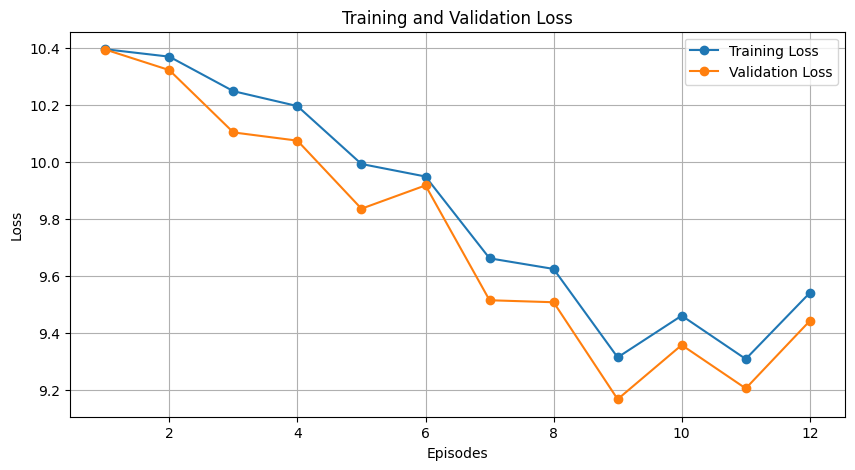

In [ ]:
import matplotlib.pyplot as plt

episodes = range(1, len(losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(episodes, losses, label="Training Loss", marker='o')
plt.plot(episodes, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from torch.amp import autocast, GradScaler
import torch.nn.utils as nn_utils


MODEL_NAME = MODEL_PATH('10', '2025-01-19-17')
LEARNING_RATE = 1e-6
LINEAR_EPISODES = 5

m = SimpleModel(
  vocab_size=len(tokenizer),
  embedding_size=EMBEDDING_SIZE,
  block_size = BLOCK_SIZE,
  layer_num=LAYER_NUM,
  attention_heads=ATTENTION_HEADS,
  dropout=DROPOUT
)

# Using torch's Adam optimizer
# Initialize AdamW optimizer
optimizer = torch.optim.AdamW(
    m.parameters(),             # Model parameters
    lr=LEARNING_RATE,                    # Learning rate
    betas=(0.9, 0.98),          # Recommended for transformers
    eps=1e-8,                   # To improve numerical stability
    weight_decay=0.01           # Regularization to prevent overfitting
)

# Using CosineAnnealingLR scheduler after a warmup
# Combined warm-up and decay scheduler
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0, total_iters=LINEAR_EPISODES),
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAIN_STEPS * TRAIN_EPISODES - LINEAR_EPISODES, eta_min=1e-5)  # Cosine decay
    ],
    milestones=[LINEAR_EPISODES]
)

# Initialize GradScaler for scaling gradients
scaler = GradScaler('cuda')

# Keeping track of the best performing model
best_loss = float('inf')

# Keeping track of the training
losses = []
val_losses = []
perplexities = []
val_perplexities = []

# Training the model
for episode in range(TRAIN_EPISODES):
  print(f'EPISODE {episode+1}')
  m.train()

  batches = get_batch(validation_files, BATCH_SIZE, BLOCK_SIZE, episode, TRAIN_STEPS)
  total_loss = 0
  for inp, out in batches:
    optimizer.zero_grad(set_to_none=True)

    with autocast('cuda'):
      logits, loss = m(inp, out)

    # Scale the loss and backpropagate
    scaler.scale(loss).backward()
    for name, param in m.named_parameters():
      if episode != 0 and param.grad is not None and torch.isnan(param.grad).any():
          print(f"NaN in gradient of {name}")

    total_loss += loss.item()

    # Gradient Clipping
    scaler.unscale_(optimizer)
    nn_utils.clip_grad_norm_(m.parameters(), MAX_NORM)

    scaler.step(optimizer)
    scaler.update()

  # Average loss and compute perplexity
  avg_loss = total_loss / TRAIN_STEPS
  perplexity = torch.exp(torch.tensor(avg_loss))
  losses.append(avg_loss)
  perplexities.append(perplexity)

  # Validation
  m.eval()
  validation_loss = 0
  with torch.no_grad():
    batches = get_batch(validation_files, BATCH_SIZE, BLOCK_SIZE, episode, VALIDATION_STEPS)
    for val_inp, val_out in batches:
      with autocast('cuda'):
        val_logits, val_loss = m(val_inp, val_out)
      validation_loss += val_loss.item()

    # Compute average validation loss
    validation_loss /= VALIDATION_STEPS
    val_perplexity = torch.exp(torch.tensor(validation_loss))
    val_losses.append(validation_loss)
    val_perplexities.append(val_perplexity)

  if episode+1 > 3 and validation_loss < best_loss:
    best_loss = validation_loss
    torch.save(m.state_dict(), MODEL_PATH('best'))

  # Step the scheduler
  scheduler.step()

  # Print and log learning rate
  for param_group in optimizer.param_groups:
      current_lr = param_group['lr']
      print(f"Current Learning Rate: {current_lr}")

  # Save model
  if (episode + 1) % 10 == 0:
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': episode,
        'best_loss': best_loss
    }, MODEL_PATH(episode+1))

  print(f'TRAIN: Loss = {loss.item():.4f} Perplexity = {perplexity:.4f}')
  print(f'EVAL : Loss = {validation_loss:.4f} Perplexity = {val_perplexity:.4f}')


# Printing a sample of generation
print(tokenizer.decode(m.generate(torch.zeros((1, 1), dtype=torch.long), 500)[0].tolist()))

EPISODE 1


Token indices sequence length is longer than the specified maximum sequence length for this model (8800 > 512). Running this sequence through the model will result in indexing errors


Current Learning Rate: 1e-06
TRAIN: Loss = 6.5160 Perplexity = 2715.9875
EVAL : Loss = 6.3756 Perplexity = 587.3295
EPISODE 2
Current Learning Rate: 1e-06
TRAIN: Loss = 6.3234 Perplexity = 1094.0461
EVAL : Loss = 6.2665 Perplexity = 526.6390
EPISODE 3
Current Learning Rate: 1e-06
TRAIN: Loss = 7.1320 Perplexity = 2086.8552
EVAL : Loss = 7.1264 Perplexity = 1244.4325
EPISODE 4
Current Learning Rate: 1e-06
TRAIN: Loss = 6.8503 Perplexity = 1682.1625
EVAL : Loss = 6.8475 Perplexity = 941.5334
EPISODE 5
Current Learning Rate: 1.0000000000000006e-06
TRAIN: Loss = 6.3467 Perplexity = 979.1552
EVAL : Loss = 6.3065 Perplexity = 548.1284
EPISODE 6
Current Learning Rate: 1.0000000987618738e-06
TRAIN: Loss = 5.7825 Perplexity = 454.6728
EVAL : Loss = 5.7144 Perplexity = 303.1944
EPISODE 7
Current Learning Rate: 1.0000003950474902e-06
TRAIN: Loss = 5.5214 Perplexity = 457.7795
EVAL : Loss = 5.4557 Perplexity = 234.0945
EPISODE 8
Current Learning Rate: 1.0000008888568395e-06
TRAIN: Loss = 4.6273 Pe

KeyboardInterrupt: 

# Testing

## Loading the model

In [ ]:
MODEL_NAME = MODEL_PATH('best', '2025-01-19-19')

model = SimpleModel(
  vocab_size=len(tokenizer),
  embedding_size=EMBEDDING_SIZE,
  block_size = BLOCK_SIZE,
  layer_num=LAYER_NUM,
  attention_heads=ATTENTION_HEADS,
  dropout=DROPOUT
)

model.load_state_dict(torch.load(MODEL_NAME, weights_only=True))
model.eval()

SimpleModel(
  (token_embedding_table): Embedding(32014, 768)
  (position_embedding_table): Embedding(512, 768)
  (decoder_blocks): Sequential(
    (0): DecoderBlock(
      (attention_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-11): 12 x SelfAttentionHead(
            (key): Linear(in_features=768, out_features=64, bias=False)
            (query): Linear(in_features=768, out_features=64, bias=False)
            (value): Linear(in_features=768, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
            (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
        )
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feedforward_layer): FeedForwardLayer(
        (network): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_

In [ ]:
GENERATED_LENGTH = 500

generated_play = tokenizer.decode(model.generate(torch.zeros((1, 1), dtype=torch.long), GENERATED_LENGTH)[0].tolist(), skip_special_tokens=False)

with open(f'/content/gdrive/MyDrive/AI/Scenarformer/generated.txt', 'w') as file:
  file.seek(0)
  play_text = generated_play.replace('<newline>', '\n').replace('<DIALOGUE>', '').replace('</DIALOGUE>', '').replace('<TITRE>', '').replace('</TITRE>', '').replace('<ACTE>', '').replace('</ACTE>', '').replace('<SCENE>', '').replace('</SCENE>', '')
  file.write(play_text)
  file.truncate()